# ML4CV Projet work - NFL Contact Detection - Nets

Giacomo Melacini - Matteo Rossi Reich - Lorenzo Tribuiani

# Introduction To The Problem


Description of the challenge from the [Kaggle](https://www.kaggle.com/competitions/nfl-player-contact-detection/overview) page:

The goal of this competition is to detect external contact experienced by players during an NFL football game. You will use video and player tracking data to identify moments with contact to help improve player safety.

In this competition, you are tasked with predicting moments of contact between player pairs, as well as when players make non-foot contact with the ground using game footage and tracking data. Each play has two associated videos. Two videos, showing a sideline and endzone view, are time synced and aligned with each other.
This year we are also providing baseline helmet detection and assignment boxes for the training and test set.

We have reduced the scope of the competition by not considering the contact between players and the ground. Morover if a player is not visible in one of the two views its contact won't be considered.


## Settings

### Imports

In [ ]:
!pip install torchinfo
!pip install wandb
%pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master
from torchviz import make_dot, make_dot_from_trace

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 28.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=e9f90b2af1d5c15c99eeac2cd5b4a56b8e869b654d3f886fc0fe824927b05276
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools
  Cloning https://github.com/szagoruyko/pytorchviz.git (to revision master) to /tmp/pip-req-build-4wc_esrt
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz.git /tmp/pip-req-build-4wc_esrt
  Resolved https://github.com/szagoruyko/pytorchviz.git to commit 0adcd83af8aa7ab36d6afd139cabbd9df598edb7
  Pre

In [ ]:
import os
import sys
from typing import Callable, Dict, List, Tuple, Union
from timeit import default_timer as timer
from tqdm.notebook import tqdm
import h5py

import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import cv2
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, matthews_corrcoef

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchinfo import summary
import wandb

from ipywidgets import widgets
from IPython.display import display

if 'google.colab' in sys.modules:
  from google.colab.patches import cv2_imshow

### Reproducibility

In [ ]:
random_seed = 42

def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    %env CUBLAS_WORKSPACE_CONFIG=:4096:8

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    return np.random.default_rng(seed)

np_random = fix_random(seed=random_seed)

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


### Runtime

The mount is needed to save data in drive and avoing long runtime restarts.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{device} selected")

cuda selected


This cell is needed to run on a local machine without trubles.

In [ ]:
if 'google.colab' in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading & Utils

## Weights & Biases

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Data Loading

We have experimented with different input image qualities and with the sampling frequency of the steps. Our main constrain was memory, hence we saved the videos in Hierarchical Data Format (HDF) in order to save space and and reduce retrival time.

In [ ]:
#@title File Paths Updating
QUALITY = "640p" #@param ["640p", "1280p"]
STEPS = "3" #@param ["3","5"]

if 'google.colab' in sys.modules:
  BASE_DIR = "/content/drive/MyDrive/nfl-player-contact-detection"
else:
  BASE_DIR = r"H:\My Drive\Uni\Uni\ML4CV\nfl-player-contact-detection"

train_df_path = f"{BASE_DIR}/{QUALITY}/dataframes/step{STEPS}/train_df_s.csv"
val_df_path = f"{BASE_DIR}/{QUALITY}/dataframes/step{STEPS}/val_df_s.csv"
test_df_path = f"{BASE_DIR}/{QUALITY}/dataframes/step{STEPS}/test_df_s.csv"

H5_train_path = f"{BASE_DIR}/{QUALITY}/H5/step{STEPS}/train_s.h5"
H5_val_path = f"{BASE_DIR}/{QUALITY}/H5/step{STEPS}/val_s.h5"
H5_test_path = f"{BASE_DIR}/{QUALITY}/H5/step{STEPS}/test_s.h5"

In [ ]:
if not os.path.exists(train_df_path) or not os.path.exists(val_df_path) or not os.path.exists(test_df_path):
  preprocess_path = f'{BASE_DIR}/ML4CV_project_work_preprocessing.ipynb'
  %run $preprocess_path


train_df = pd.read_csv(train_df_path)
val_df = pd.read_csv(val_df_path)
test_df = pd.read_csv(test_df_path)


In [ ]:
train_hf = h5py.File(H5_train_path, 'r')
val_hf = h5py.File(H5_val_path, 'r')
test_hf = h5py.File(H5_test_path, 'r')

In [ ]:
train_sideline = train_hf.get('frames_sideline')
train_endzone = train_hf.get('frames_endzone')
train_keys = train_hf.get('keys')[:]

In [ ]:
val_sideline = val_hf.get('frames_sideline')
val_endzone = val_hf.get('frames_endzone')
val_keys = val_hf.get('keys')[:]

In [ ]:
test_sideline = test_hf.get('frames_sideline')
test_endzone = test_hf.get('frames_endzone')
test_keys = test_hf.get('keys')[:]

## Data Visualization

### Utils

Given a gameplay, a frame number and the selecte view this function loads a single frame and checks whether the frame is correct.

In [ ]:
def get_frame(game_play, frame_num, view):
  path = f'{BASE_DIR}/{QUALITY}/train/{game_play}_{view}.mp4'

  cap = cv2.VideoCapture(path)

  cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
  ret, frame = cap.read()

  if not ret:
    frame = np.zeros((720, 1280, 3))
    print(f'Invalid frame in {view} video for gameplay {game_play} at frame {frame_num}')

  return ret, frame

This function draws the helmets on top of the frame.

In [ ]:
def draw_helmet(frame, contact, view):
  h_view = 's' if view == 'Sideline' else 'e'
  helmet_color = (0,0,0)
  cv2.rectangle(
              frame,
              (contact[f'left_{h_view}_1'].astype(int), contact[f'top_{h_view}_1'].astype(int)),
              ((contact[f'left_{h_view}_1'] + contact[f'width_{h_view}_1']).astype(int), (contact[f'top_{h_view}_1'] + contact[f'height_{h_view}_1']).astype(int)),
              helmet_color,
              thickness=2,
          )
  cv2.rectangle(
              frame,
              (contact[f'left_{h_view}_2'].astype(int), contact[f'top_{h_view}_2'].astype(int)),
              ((contact[f'left_{h_view}_2'] + contact[f'width_{h_view}_2']).astype(int), (contact[f'top_{h_view}_2'] + contact[f'height_{h_view}_2']).astype(int)),
              helmet_color,
              thickness=2,
          )


This function draws the contact as box on top of the frame.

In [ ]:
def draw_contact(frame, contact, view, are_points=True):
  h_view = 's' if view == 'Sideline' else 'e'
  if not are_points:
    x1 = contact[f'left_{h_view}'].astype(int)
    y1 = contact[f'top_{h_view}'].astype(int)
    x2 = (contact[f'left_{h_view}'] + contact[f'width_{h_view}']).astype(int)
    y2 = (contact[f'top_{h_view}'] + contact[f'height_{h_view}']).astype(int)
  else:
    x1, y1 = int(contact[f'x1_{h_view}']), int(contact[f'y1_{h_view}'])
    x2, y2 = int(contact[f'x2_{h_view}']), int(contact[f'y2_{h_view}'])

  contact_color = (0, 255, 0)
  cv2.rectangle(
              frame,
              (x1, y1),
              (x2, y2),
              contact_color,
              thickness=1,
          )

Given a contact the following function displays the relevant frame. There is an option for showing the the bounding box describing the contact region and an option to show the bounding boxes of the helmets of the players involved in the contact.

In [ ]:
def show_frame_from_contact(contact, view, show_helmets=True, show_contact=False, are_points=False):
  _, frame = get_frame(contact.game_play, contact.frame, view)

  if show_helmets:
    draw_helmet(frame, contact, view)

  if show_contact:
    draw_contact(frame, contact, view, are_points=are_points)

  print(f'Showing frame of game_play {contact.game_play}, step {contact.step} for players {contact.nfl_player_id_1} and {contact.nfl_player_id_2}')
  cv2_imshow(frame)

This function is used to print a frame with all the contacts on it. It is used for debugging purposes.

In [ ]:
def show_example(example, view='Sideline'):
  _, frame = get_frame(example.game_play.to_list()[0], example.frame.to_list()[0], view)

  for _, row in example.iterrows():
    if row[f'{view.lower()}_mask']:
      draw_contact(frame, row, view)

  print(f'Showing frame of game_play {example.game_play.to_list()[0]}, step {example.step.to_list()[0]}')
  cv2_imshow(frame)

### Dataframes

In [ ]:
train_df.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,example_id,game_play,step,frame,nfl_player_id_1,nfl_player_id_2,contact,...,height_e_2,x1_s,y1_s,x1_e,y1_e,x2_s,y2_s,x2_e,y2_e,mapping_index
0,0,0,0,58168_003392_0,58168_003392,0,299,37084,37211,0,...,16.0,187.0,232.0,74.0,132.0,249.0,259.0,209.0,180.0,0
1,1,1,1,58168_003392_0,58168_003392,0,299,37084,38556,0,...,11.0,242.0,141.0,198.0,142.0,279.0,168.0,620.0,175.0,0
2,2,2,2,58168_003392_0,58168_003392,0,299,37084,38567,0,...,17.0,219.0,228.0,190.0,138.0,249.0,260.0,209.0,190.0,0
3,3,3,3,58168_003392_0,58168_003392,0,299,37084,38590,0,...,17.0,234.0,185.0,198.0,144.0,249.0,212.0,416.0,195.0,0
4,4,4,4,58168_003392_0,58168_003392,0,299,37084,39947,0,...,16.0,237.0,170.0,198.0,139.0,249.0,197.0,483.0,189.0,0


In [ ]:
val_df.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,example_id,game_play,step,frame,nfl_player_id_1,nfl_player_id_2,contact,...,height_e_2,x1_s,y1_s,x1_e,y1_e,x2_s,y2_s,x2_e,y2_e,mapping_index
0,0,0,0,58168_003392_48,58168_003392,48,587,37084,37211,0,...,17.0,226.0,149.0,339.0,107.0,330.0,186.0,403.0,165.0,0
1,1,1,1,58168_003392_48,58168_003392,48,587,37084,38556,0,...,NaN,226.0,72.0,NaN,NaN,373.0,110.0,NaN,NaN,0
2,2,2,2,58168_003392_48,58168_003392,48,587,37084,38567,0,...,NaN,226.0,90.0,NaN,NaN,451.0,128.0,NaN,NaN,0
3,3,3,3,58168_003392_48,58168_003392,48,587,37084,38590,0,...,15.0,226.0,95.0,339.0,108.0,471.0,132.0,614.0,166.0,0
4,4,4,4,58168_003392_48,58168_003392,48,587,37084,39947,0,...,NaN,226.0,54.0,NaN,NaN,471.0,91.0,NaN,NaN,0


In [ ]:
test_df.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,example_id,game_play,step,frame,nfl_player_id_1,nfl_player_id_2,contact,...,height_e_2,x1_s,y1_s,x1_e,y1_e,x2_s,y2_s,x2_e,y2_e,mapping_index
0,0,0,0,58168_003392_30,58168_003392,30,479,37084,37211,0,...,11.0,NaN,NaN,214.0,128.0,NaN,NaN,275.0,168.0,0
1,1,1,1,58168_003392_30,58168_003392,30,479,37084,38556,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2,2,2,58168_003392_30,58168_003392,30,479,37084,38567,0,...,15.0,NaN,NaN,214.0,154.0,NaN,NaN,393.0,201.0,0
3,3,3,3,58168_003392_30,58168_003392,30,479,37084,38590,0,...,12.0,NaN,NaN,214.0,135.0,NaN,NaN,445.0,175.0,0
4,4,4,4,58168_003392_30,58168_003392,30,479,37084,39947,0,...,16.0,NaN,NaN,214.0,145.0,NaN,NaN,598.0,193.0,0


### Contact

Showing frame of game_play 58168_003392, step 12 for players 37084 and 45695


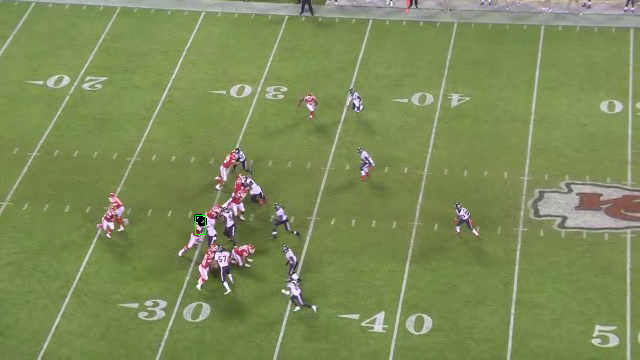

In [ ]:
show_frame_from_contact(train_df.loc[train_df.contact == 1].iloc[0, :], 'Sideline', show_helmets=True, show_contact=True, are_points=True)

### Example

Showing frame of game_play 58168_003392, step 0


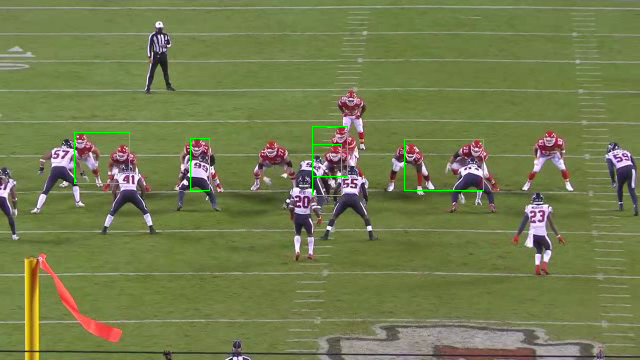

In [ ]:
show_example(train_df.iloc[0:231, :], view='Endzone')

# Statistics

We are interested in knowing for how many players we will compute the loss, since players which are far apart or are not visible won't be considered and therefore shoudn't influence the loss.

In [ ]:
loss_count = train_df[train_df.loss_mask == True].groupby(by='contact').count().iloc[:, 0].to_list()
loss_freq = loss_count / np.sum(loss_count)
class_weight = 1 - loss_freq
loss_count, loss_freq, class_weight

([35487, 12133], array([0.7452121, 0.2547879]), array([0.2547879, 0.7452121]))

In [ ]:
sideline_count = train_df[train_df.sideline_mask == True].groupby(by=['contact']).count().iloc[:, 0].to_list()
sideline_count

[31802, 10945]

In [ ]:
endzone_count = train_df[train_df.endzone_mask == True].groupby(by=['contact']).count().iloc[:, 0].to_list()
endzone_count

[30402, 10622]

# Metrics

Here we define all the metric we used.

In [ ]:
def compute_metrics(y_true=None, y_pred=None, mask=None, logits=False, cuda = True, start=False):

  if start:
    return {'accuracy': 0., 'f1': 0., 'precision' : 0., 'recall' : 0.}

  if mask is not None:
    y_true = y_true[mask]
    y_pred = y_pred[mask]

  if logits:
    sigmoid = torch.nn.Sigmoid()
    y_pred = sigmoid(y_pred)

  if cuda:
    y_pred = y_pred.to('cpu')
    y_true = y_true.to('cpu')

  y_pred[np.where(y_pred >= 0.5)] = 1
  y_pred[np.where(y_pred < 0.5)] = 0

  acc = accuracy_score(y_true, y_pred)
  prec, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)

  metrics = {'accuracy': acc,
            'f1': f1,
            'precision' : prec,
            'recall' : recall}

  return metrics

# Loss function

Here we define the loss function. We have tried two different ones: the standard BCE and the Focal Loss.
As shown in the **Statistics** section, even after pruning most of the unprobable contacts, we are still left with an imbalanced dataset. This is why we tried to use the focal loss. In this way easy to classify examples would not contribute heavily to the loss.

In [ ]:
def focal_loss(scores, labels, mask):

  scores = scores[mask]
  labels = labels[mask]

  output = torchvision.ops.sigmoid_focal_loss(scores, labels, gamma=2, reduction='mean')

  return output

In [ ]:
def bce_loss(scores, labels, mask):

  scores = scores[mask]
  labels = labels[mask]

  loss = torch.nn.BCEWithLogitsLoss()
  # output = torchvision.ops.sigmoid_focal_loss(scores, labels, gamma=2)
  output = loss(scores, labels)
  return output

In [ ]:
def bce_loss_no_mask(scores, labels):
  loss = torch.nn.BCEWithLogitsLoss()
  output = loss(scores, labels)
  return output

# Baseline

Here we propose two baselines: one that sets all contacts to zero and the other that selects contacts randomly based on their frequency in the training set.

### Baseline-1

All zeroes.

In [ ]:
compute_metrics(test_df.contact.to_numpy(), np.zeros(len(test_df)), test_df.loss_mask.to_numpy(), logits=False, cuda=False)

{'accuracy': 0.7591721542803387, 'f1': 0.0, 'precision': 0.0, 'recall': 0.0}

In [ ]:
matthews_corrcoef(test_df.contact.to_numpy(), np.zeros(len(test_df)))

0.0

### Baseline-2

At random.

In [ ]:
random_pred = np_random.choice([0,1], size=len(test_df), p=loss_freq)

In [ ]:
compute_metrics(test_df.contact.to_numpy(), random_pred, test_df.loss_mask.to_numpy(), logits=False, cuda=False)

{'accuracy': 0.617826904985889,
 'f1': 0.22582181991424488,
 'precision': 0.22046511627906976,
 'recall': 0.2314453125}

In [ ]:
matthews_corrcoef(test_df.contact.to_numpy(), random_pred)

-0.004714301778333344

# Training functionalities

### Utils

We use ResNet50 as a backbone feature extractor and we don't want to retrain all of it. This function allows to freeze layers at need.

In [ ]:
def set_requires_grad_for_layer(layer: torch.nn.Module, train: bool) -> None:
    """Sets the attribute requires_grad to True or False for each parameter.

        Args:
            layer: the layer to freeze.
            train: if true train the layer.
    """
    for p in layer.parameters():
        p.requires_grad = train

### Train

This is the training function, which includes the log to Weight and Biases.

In [ ]:
# Train one epoch
def train(model: torch.nn.Module,
          train_loader: DataLoader,
          val_loader: DataLoader,
          optimizer: torch.optim,
          criterion: Callable,
          metrics: Callable,
          device,
          validate_interval=100) -> Tuple[float, dict]:
    """Trains a neural network for one epoch.

    Args:
        model: the model to train.
        train_loader: the data loader containing the training data.
        optimizer: the optimizer to use to train the model.
        criterion: the loss to optimize.
        metrics: a function that compute the metrics.

    Returns:
        the cross entropy Loss value on the training data.
        the metrics on the training data.
    """
    samples_train = 0
    metrics_train = metrics(start=True)
    metrics_train['loss'] = 0.

    progress_bar = tqdm(train_loader) #fancy progress bar
    model.train()
    for idx_batch, (input, labels) in enumerate(train_loader):
        #frames, contact_boxes, masks = input[0].to(device), input[1].to(device), input[2].to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        scores = model(**input)

        loss = criterion(scores, labels, input['mask'][:, :, 0])

        loss.backward()
        optimizer.step()

        new_metrics = metrics(labels.detach(), scores.detach(), input['mask'][:, :, 0])

        n_checks = torch.sum(input['mask'][:, :, 0]).item()
        samples_train += n_checks

        metrics_train.update((key, new_value.item() * n_checks + metrics_train[key]) for key, new_value in new_metrics.items())
        metrics_train['loss'] += loss.item() * n_checks

        # Validate
        if validate_interval != -1 and idx_batch % validate_interval == 0:
          #here we log for wandb
          metrics_val = validate(model, val_loader, criterion, metrics, device)
          log_dict_train = {key + "_train": value / samples_train for key, value in metrics_train.items()}
          log_dict_val = {key + "_val": value for key, value in metrics_val.items()}
          wandb.log({**log_dict_train, **log_dict_val})

        progress_bar.update(1)

    metrics_train.update((key, value / samples_train) for key, value in metrics_train.items())

    return metrics_train

### Validate

This is the validation function.

In [ ]:
# Validate one epoch
def validate(model: torch.nn.Module,
             data_loader: DataLoader,
             criterion: Callable,
             metrics: Callable,
             device) -> Tuple[float, dict]:
    """Validates a neural network for one epoch.

    Args:
        model: the model to validate.
        data_loader: the data loader containing the validation data.
        criterion: the loss to optimize.
        metrics: a function that compute the metrics

    Returns:
        the cross entropy Loss value on the validation data.
        the metrics on the training data.
    """
    samples_val = 0
    metrics_val = metrics(start=True)
    metrics_val['loss'] = 0.

    progress_bar = tqdm(data_loader) #fancy bar
    model = model.eval()
    with torch.no_grad():
        for idx_batch, (input, labels) in enumerate(data_loader):
            #frames, contact_boxes, masks = input[0].to(device), input[1].to(device), input[2].to(device)
            labels = labels.to(device)

            scores = model(**input)

            loss = criterion(scores, labels, input['mask'][:, :, 0])

            new_metrics = metrics(labels.detach(), scores.detach(), input['mask'][:, :, 0])

            n_checks = torch.sum(input['mask'][:, :, 0]).item()
            samples_val += n_checks

            metrics_val.update((key, new_value.item() * n_checks + metrics_val[key]) for key, new_value in new_metrics.items())
            metrics_val['loss'] += loss.item() * n_checks

            progress_bar.update(1)


    metrics_val.update((key, value / samples_val) for key, value in metrics_val.items())

    return metrics_val

### Predict

This is the prediction function.

In [ ]:
# Validate one epoch
def predict(model: torch.nn.Module,
            data_loader: DataLoader,
            criterion: Callable,
            metrics: Callable,
            device,
            has_mask = True) -> Tuple[torch.Tensor, float, dict]:
    """Makes prediction from a neural network.

    Args:
        model: the model to validate.
        data_loader: the data loader containing the validation data.
        criterion: the loss to optimize.
        metrics: a function that compute the metrics

    Returns:
        the predicted values
        the cross entropy Loss value on the validation data.
        the metrics on the training data.
    """
    samples_pred = 0
    metrics_pred = metrics(start=True)
    metrics_pred['loss'] = 0.

    y_pred = torch.tensor([]).to(device)
    total_steps = len(data_loader)
    progress_bar = tqdm(data_loader)
    model = model.eval()
    with torch.no_grad():
        for (input, labels) in data_loader:
            #frames, contact_boxes, masks = input[0].to(device), input[1].to(device), input[2].to(device)
            labels = labels.to(device)

            scores = model(**input)

            if has_mask:
              loss = criterion(scores, labels, input['mask'][:, :, 0])

              new_metrics = metrics(labels.detach(), scores.detach(), input['mask'][:, :, 0])

              n_checks = torch.sum(input['mask'][:, :, 0]).item()
              samples_pred += n_checks

              metrics_pred.update((key, new_value.item() * n_checks + metrics_pred[key]) for key, new_value in new_metrics.items())
              metrics_pred['loss'] += loss.item() * n_checks


            else:
              loss = criterion(scores, labels)

              new_metrics = metrics(labels.detach(), scores.detach())


              metrics_pred.update((key, new_value.item() + metrics_pred[key]) for key, new_value in new_metrics.items())
              metrics_pred['loss'] += loss.item()

            y_pred = torch.cat((y_pred, torch.flatten(scores)))
            progress_bar.update(1)
    if has_mask:
      metrics_pred.update((key, value / samples_pred) for key, value in metrics_pred.items())
    else:
      metrics_pred.update((key, value / total_steps) for key, value in metrics_pred.items())

    sigmoid = torch.nn.Sigmoid()

    return sigmoid(y_pred), metrics_pred

### Training loop

This is the training loop.

In [ ]:
def training_loop(model: torch.nn.Module,
                  train_loader: DataLoader,
                  val_loader: DataLoader,
                  num_epochs: int,
                  optimizer: torch.optim,
                  criterion: Callable,
                  metrics: Callable,
                  device,
                  validate_interval=100,
                  verbose=True,
                  saving_path = "",
                  metric_monitor = "accuracy") -> Dict:
    """Executes the training loop.

        Args:
            model: the mode to train.
            train_loader: the data loader containing the training data.
            val_loader: the data loader containing the validation data.
            num_epochs: the number of epochs.
            optimizer: the optimizer to use.
            criterion: the loss to optimize.
            metrics: a function that compute the metrics.
            verbose: if true print the value of loss and metrics.
            saving_path: the path to the file (including the .pt) where the model will be saved
            metric_monitor: metric choosen to be the monitor for saving the model

        Returns:
            A dictionary with the statistics computed during the train:
            the values for the train loss for each epoch.
            the values for the train metrics for each epoch.
            the values for the validation metrics for each epoch.
            the time of execution in seconds for the entire loop.
    """
    model = model.to(device)

    loop_start = timer()

    train_metric_values = metrics(start=True)
    train_metric_values['loss'] = 0.
    train_metric_values.update((key, []) for key, _ in train_metric_values.items())

    val_metric_values = metrics(start=True)
    val_metric_values['loss'] = 0.
    val_metric_values.update((key, []) for key, _ in val_metric_values.items())
    best_metric = float('-inf')
    # print("train_metric_value", train_metric_values)
    for epoch in range(1, num_epochs + 1):
        time_start = timer()

        # print('TRAIN')
        metrics_train = train(model, train_loader, val_loader, optimizer, criterion, metrics, device, validate_interval=validate_interval)
        # print('VALIDATE')
        metrics_val = validate(model, val_loader, criterion, metrics, device)

        time_end = timer()
        # print(metrics_train)
        train_metric_values.update((key, value + [metrics_train[key]]) for key, value in train_metric_values.items())
        val_metric_values.update((key, value + [metrics_val[key]]) for key, value in val_metric_values.items())
        # print("train_metric_value", train_metric_values)

        lr = optimizer.param_groups[0]['lr']

        if validate_interval == -1:
            log_dict_train = {key + "_train": value for key, value in metrics_train.items()}
            log_dict_val = {key + "_val": value for key, value in metrics_val.items()}
            wandb.log({**log_dict_train, **log_dict_val})

        if metrics_val[metric_monitor] > best_metric:
          print(f"{metric_monitor} improved from {best_metric} to {metrics_val[metric_monitor]}, Saving model...")
          best_metric = metrics_val[metric_monitor]
          torch.save(model.state_dict(), saving_path)

        if verbose:
            text_train = [key + "_train: " + str(round(value, 4)) for key, value in metrics_train.items()]
            text_val = [key + "_val: " + str(round(value, 4)) for key, value in metrics_val.items()]
            print(f'Epoch: {epoch} '
                  f' METRICS TRAIN: {" - ".join(text_train)} '
                  f' METRICS VAL: {" - ".join(text_val)} '
                  f' Time one epoch (s): {(time_end - time_start):.4f} ')


    loop_end = timer()
    time_loop = loop_end - loop_start
    if verbose:
        print(f'Time for {num_epochs} epochs (s): {(time_loop):.3f}')

    return {'train': train_metric_values,
            'val': val_metric_values,
            'time': time_loop}

# Pytorch

### Utils

We use ResNet50 as a feature extractor, hence in order to normalize and denormalize an image we have to use its mean and standard deviation values.

In [ ]:
mean_image_net = [0.485, 0.456, 0.406]
std_image_net = [0.229, 0.224, 0.225]

class NormalizeInverse(torchvision.transforms.Normalize):
    def __init__(self, mean: List[float], std: List[float]) -> None:
        """Reconstructs the images in the input domain by inverting
        the normalization transformation.

        Args:
            mean: the mean used to normalize the images.
            std: the standard deviation used to normalize the images.
        """
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())



denormalize = NormalizeInverse(mean_image_net, std_image_net)

This function allows to visalize an example with the contact boxes (in red if there is an actual contact) after it has been insterted in the dataset.

In [ ]:
def show_pytorch_example(example, view='Sideline', show_contacts=True):
  (input, contacts) = example

  frames = input['frame']
  masks = input['mask']
  contact_boxes = input['contact']

  ch = 0 if view=='Sideline' else 1

  frame = denormalize(frames[ch].to('cpu')).numpy() * 255

  frame = np.transpose(frame, (1, 2, 0)).astype(np.uint8).copy()

  if show_contacts:
    mask = masks.to('cpu').numpy()[:, ch + 1]
    contact_boxes = contact_boxes[ch].to('cpu').numpy()[mask].astype(int)
    contacts = contacts.to('cpu').numpy()[mask]
    for i, box in enumerate(contact_boxes):
      if contacts[i] == 1:
        contact_color = (0, 0, 255)
      else:
        contact_color = (0, 255, 0)

      cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), contact_color, thickness=1)

  cv2_imshow(frame)

In [ ]:
def show_prediction(input, true_contacts, predicted_contacts, view='Sideline'):
  frames = input['frame']
  masks = input['mask']
  contact_boxes = input['contact']

  ch = 0 if view=='Sideline' else 1

  frame = denormalize(frames[ch].to('cpu')).numpy() * 255

  frame = np.transpose(frame, (1, 2, 0)).astype(np.uint8).copy()


  mask = masks.to('cpu').numpy()[:, ch + 1]

  contact_boxes = contact_boxes[ch].to('cpu').numpy()[mask].astype(int)
  true_contacts = true_contacts.to('cpu').numpy()[mask]
  predicted_contacts = predicted_contacts.to('cpu').numpy()[mask]

  for i, box in enumerate(contact_boxes):
    if true_contacts[i] == 1 and predicted_contacts[i] == 1:
      contact_color = (0, 255, 0)
    elif true_contacts[i] == 0 and predicted_contacts[i] == 0:
      contact_color = (255, 0, 0)
    elif true_contacts[i] == 0 and predicted_contacts[i] == 1:
      contact_color = (0, 0, 255)
    else:
      contact_color = (0, 0, 0)

    cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), contact_color, thickness=1)

  cv2_imshow(frame)

This function allows to show TP, TN, FP, and FN for the second model approach

In [ ]:
def inputs_from_gpframe(game_play, frame, df, model):
  examples = df[(df.game_play == game_play) & (df.frame == frame)]
  map = examples.mapping_index.iloc[0]

  croping_size = 128
  in_s = torch.empty((0, 3, 128, 128))
  in_e = torch.empty((0, 3, 128, 128))
  ma_s = torch.empty((0, 1, 128, 128))
  ma_e = torch.empty((0, 1, 128, 128))
  labels = []
  distances = []
  contact_boxes = []

  for index, example in examples.iterrows():
    center_x_s = int(example.x1_s + ((example.x2_s - example.x1_s) / 2))
    center_y_s = int(example.y1_s + ((example.y2_s - example.y1_s) / 2))

    center_x_e = int(example.x1_e + ((example.x2_e - example.x1_e) / 2))
    center_y_e = int(example.y1_e + ((example.y2_e - example.y1_e) / 2))

    contact_boxes.append([[int(example.x1_s), int(example.y1_s), int(example.x2_s), int(example.y2_s)],
                          [int(example.x1_e), int(example.y1_e), int(example.x2_e), int(example.y2_e)]])

    sideline_frame = torchvision.transforms.ToTensor()(test_sideline[map])
    endzone_frame = torchvision.transforms.ToTensor()(test_endzone[map])
    sideline_frame /= 255
    endzone_frame /= 255
    fheight = sideline_frame.shape[1]
    fwidth = sideline_frame.shape[2]

    mask_s = torch.zeros((1,360,640))
    mask_e = torch.zeros((1,360,640))
    mask_s[:, int(example.y1_s) : int(example.y2_s), int(example.x1_s) : int(example.x2_s)] = 1
    mask_e[:, int(example.y1_e) : int(example.y2_e), int(example.x1_e) : int(example.x2_e)] = 1


    #if cropped image boundaries are outside the image than zero padding is added (sideline)
    if (center_x_s + croping_size //2) > fwidth or (center_x_s - croping_size //2) < 0 or (center_y_s + croping_size // 2) > fheight or (center_y_s - croping_size //2) < 0:
      x_padding = max(fwidth - (center_x_s + croping_size //2), abs(center_x_s - croping_size //2))
      y_padding = max(fheight - (center_y_s + croping_size // 2), abs((center_y_s - croping_size //2)))
      sideline_frame = torch.nn.functional.pad(sideline_frame, (x_padding, x_padding, y_padding, y_padding))
      mask_s = torch.nn.functional.pad(mask_s, (x_padding, x_padding, y_padding, y_padding))
      center_x_s += x_padding # update x position with padding
      center_y_s += y_padding # update y position eith padding

    #if cropped image boundaries are outside the image than zero padding is added (sideline)
    if (center_x_e + croping_size //2) > fwidth or (center_x_e - croping_size //2) < 0 or (center_y_e + croping_size // 2) > fheight or (center_y_e - croping_size //2) < 0:
      x_padding = max(fwidth - (center_x_e + croping_size //2), abs(center_x_e - croping_size //2))
      y_padding = max(fheight - (center_y_e + croping_size // 2), abs((center_y_e - croping_size //2)))
      endzone_frame = torch.nn.functional.pad(endzone_frame, (x_padding, x_padding, y_padding, y_padding))
      mask_e = torch.nn.functional.pad(mask_e, (x_padding, x_padding, y_padding, y_padding))
      center_x_e += x_padding # update x position with padding
      center_y_e += y_padding # update y position with padding

    input_s = sideline_frame[:, center_y_s - croping_size//2 : center_y_s + croping_size//2,
                    center_x_s - croping_size//2 : center_x_s + croping_size//2]

    input_e = endzone_frame[:, center_y_e - croping_size//2 : center_y_e + croping_size//2,
                    center_x_e - croping_size//2 : center_x_e + croping_size//2]

    mask_s = mask_s[:, center_y_s - croping_size//2 : center_y_s + croping_size//2,
                    center_x_s - croping_size//2: center_x_s + croping_size//2]

    mask_e = mask_e[:, center_y_e - croping_size//2  : center_y_e + croping_size//2,
                    center_x_e - croping_size//2  : center_x_e + croping_size//2]

    labels.append(example.contact)
    distances.append(example.distance)

    in_s = torch.cat((in_s, input_s[None, :]), dim=0)
    in_e = torch.cat((in_e, input_e[None, :]), dim=0)
    ma_e = torch.cat((ma_e, mask_e[None, :]), dim=0)
    ma_s = torch.cat((ma_s, mask_s[None, :]), dim=0)

  labels = torch.tensor(labels)
  distances = torch.tensor(distances)

  print("Calculating predictions...")
  predictions = model(in_s.to(device), in_e.to(device), ma_s.to(device), ma_e.to(device), distances.to(device))
  predictions[predictions < 0.5] = 0
  predictions[predictions >= 0.5] = 1

  print("Creating graphs...")
  TP = []
  TN = []
  FP = []
  FN = []
  for i in range(0, len(labels)):
    if labels[i] == 0 and predictions[i] == 0:
      TN.append(i)
    elif labels[i] == 0 and predictions[i] == 1:
      FP.append(i)
    elif labels[i] == 1 and predictions[i] == 0:
      FN.append(i)
    elif labels[i] == 1 and predictions[i] == 1:
      TP.append(i)

  sideline_frame = test_sideline[map]
  for i in TP:
    sideline_frame_TP = cv2.rectangle(sideline_frame, (contact_boxes[i][0][0],contact_boxes[i][0][1]), (contact_boxes[i][0][2], contact_boxes[i][0][3]), (0,255,0), 1)

  sideline_frame = test_sideline[map]
  for i in TN:
    sideline_frame_TN = cv2.rectangle(sideline_frame, (contact_boxes[i][0][0],contact_boxes[i][0][1]), (contact_boxes[i][0][2], contact_boxes[i][0][3]), (0,255,0), 1)

  sideline_frame = test_sideline[map]
  for i in FP:
    sideline_frame_FP = cv2.rectangle(sideline_frame, (contact_boxes[i][0][0],contact_boxes[i][0][1]), (contact_boxes[i][0][2], contact_boxes[i][0][3]), (255,0,0), 1)

  sideline_frame = test_sideline[map]
  for i in FN:
    sideline_frame_FN = cv2.rectangle(sideline_frame, (contact_boxes[i][0][0],contact_boxes[i][0][1]), (contact_boxes[i][0][2], contact_boxes[i][0][3]), (255,0,0), 1)

  fig, ax = plt.subplots(2, 2, figsize=(15,10))

  sideline_frame = test_sideline[map]
  if len(TP) > 0:
    ax[0][0].imshow(sideline_frame_TP)
  else:
    ax[0][0].imshow(sideline_frame)
  ax[0][0].set_title(f"True Positive: {len(TP)}")

  if len(TN) > 0:
    ax[0][1].imshow(sideline_frame_TN)
  else:
    ax[0][1].imshow(sideline_frame)
  ax[0][1].set_title(f"True Negative: {len(TN)}")

  if len(FP) > 0:
    ax[1][0].imshow(sideline_frame_FP)
  else:
    ax[1][0].imshow(sideline_frame)
  ax[1][0].set_title(f"False Positive: {len(FP)}")

  if len(FN) > 0:
    ax[1][1].imshow(sideline_frame_FN)
  else:
    ax[1][1].imshow(sideline_frame)
  ax[1][1].set_title(f"False Negative: {len(FN)}")

  plt.show()

# Neural networks & Datasets

## First Approach: ForkNet SIML (*Single Image Multi Label*)

### Dataset

Here is where the pytorch dataset is defined. The transformations applied to each input are the normalization of the image and the transformation to tensor of both image and tabular data.

Each example consists of two images (same gameplay-step visualized both from the Sideline and from the Endzone view), and the information about each of the 231 possible combinations of players. For each combination we have the contact bounding box (for both views), a mask to tell us whether to evaluate the contact or not (and consider it for the loss) and a contact label.

The example will be formatted as follows:
- Input
  - Images → (2, 3, height, width)
  - Contact boxes → (2, 231, 4)
  - Masks → (231, 3)
- Output
  - Label → (231)

In [ ]:
class NFLDataset_SIML(Dataset):

  def __init__(self, df, sideline, endzone, keys, augment=False):

    self.df = df
    self.sideline = sideline
    self.endzone = endzone
    self.keys = [k.decode("utf-8") for k in keys[:]]

    self.length = len(keys)

    normalize = torchvision.transforms.Normalize(mean_image_net, std_image_net)
    if augment:
      self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.ColorJitter(0.5, 0.5, 0.5, 0.5), normalize])
    else:
      self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), normalize])

  def __len__(self):
    return self.length

  def __getitem__(self, idx):

    key = self.keys[idx]

    game_play = key[0:12]
    step = int(key[13:])

    example = self.df.loc[(self.df.game_play == game_play) & (self.df.step == step)]
    if len(example) > 231:
      print(key)


    # Get frames
    frame_sideline = self.sideline[idx]
    ret_sideline, ret_endzone = True, True
    if np.sum(frame_sideline) == 0:
      ret_sideline = False

    frame_endzone = self.endzone[idx]
    if np.sum(frame_endzone) == 0:
      ret_endzone = False

    frames = torch.stack((self.transform(frame_sideline), self.transform(frame_endzone)))

    # Get contact boxes
    contact_boxes_sideline = torch.tensor(example.loc[:, ['x1_s', 'y1_s', 'x2_s', 'y2_s']].to_numpy(), dtype = torch.float)
    contact_boxes_endzone = torch.tensor(example.loc[:, ['x1_e', 'y1_e', 'x2_e', 'y2_e']].to_numpy(), dtype = torch.float)
    contact_boxes = torch.stack((contact_boxes_sideline, contact_boxes_endzone))

    # Get masks
    masks = torch.tensor(example.loc[:, ['loss_mask', 'sideline_mask', 'endzone_mask']].to_numpy())
    if not ret_sideline:
      masks[:, 1] = False
    if not ret_endzone:
      masks[:, 2] = False
    masks[:, 0] = torch.logical_and(masks[:, 1], masks[:, 2])

    # Get contacts
    contacts = torch.tensor(example.loc[:, 'contact'].to_numpy(), dtype=torch.float32)

    inputs = {
        "frame" : frames,
        "contact" : contact_boxes,
        "mask" : masks
    }

    return (inputs, contacts)

We create here the dataset for training test and validation. We also built a small dataset for testing purposes and to test the capacity of the network.

In [ ]:
train_ds_SIML = NFLDataset_SIML(train_df, train_sideline, train_endzone, train_keys)
val_ds_SIML = NFLDataset_SIML(val_df, val_sideline, val_endzone, val_keys)
test_ds_SIML = NFLDataset_SIML(test_df, test_sideline, test_endzone, test_keys)

train_ds_aug_SIML = NFLDataset_SIML(train_df, train_sideline, train_endzone, train_keys, augment=True)

In [ ]:
small_train_ds_SIML = NFLDataset_SIML(train_df, train_sideline[[0,40,60]], train_endzone[[0,40,60]], train_keys[[0,40,60]])
small_val_ds_SIML = NFLDataset_SIML(val_df, val_sideline[:2], val_endzone[:2], val_keys[:2])

Let's visualize a complete example. The green and red boxes show the portions of image that have to be analyzed for contact detection. The red ones mean that there is a contact.

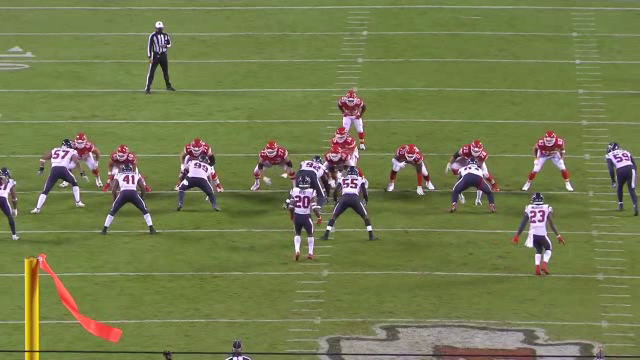

In [ ]:
show_pytorch_example(train_ds_SIML.__getitem__(0), 'Endzone', show_contacts=False)

#### Dataloaders example

Here we created a data loader for the test dataset.

In [ ]:
num_workers = 2

small_loader_train = torch.utils.data.DataLoader(small_train_ds_SIML, batch_size=3,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=num_workers)
small_loader_val = torch.utils.data.DataLoader(small_val_ds_SIML, batch_size=2,
                                         shuffle=False,
                                         num_workers=num_workers)

As we can observe, the input has lenght 3. The first element is made of the stacked images, the second one contains the contact boxes (one for each combination of players) and the third one contains the mask for the evaluation.

In [ ]:
example_batch = next(iter(small_loader_train))
print(f'The returned tuple has size {len(example_batch)}\n'
      f'The output has shape {example_batch[1].shape}\n'
      f'The input has lenght {len(example_batch[0])}\n'
      f'Frames have shape {example_batch[0]["frame"].shape}\n'
      f'Contact boxes have shape {example_batch[0]["contact"].shape}\n'
      f'Masks shape {example_batch[0]["mask"].shape}\n'
      f'Sideline_checks {torch.sum(example_batch[0]["mask"][:, :, 1])}')

The returned tuple has size 2
The output has shape torch.Size([3, 231])
The input has lenght 3
Frames have shape torch.Size([3, 2, 3, 360, 640])
Contact boxes have shape torch.Size([3, 2, 231, 4])
Masks shape torch.Size([3, 231, 3])
Sideline_checks 19


### Network

#### Architechture Description

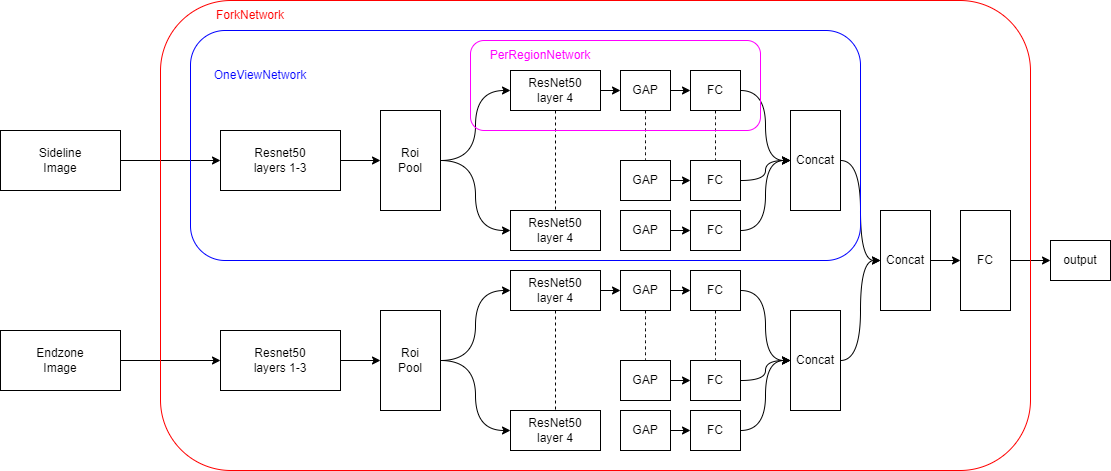

Even if this is not an object detection task, it shares with it many features:
- We do not have to classify the entire image, but portions of it;
- For each image there are many regions to be classified (10 on average);
- These regions are defined by boxes that can overlap.

A difference w.r.t. a classical object detection problem is that we already have the contact boxes, i.e. we do not need a Region Proposal Network, and of course we are not classifying object but detecting whether a contact has taken place or not.

These are the reasons that brought us to the decision of using a network inspired by Fast R-CNN with ResNet50.

Each frame is processed by a feature extractor made of the first 3 freezed layers of ResNet50. The feature extractor produces a feature map that, together with the contact boxes, is processed by our OneViewNetwork. This net takes the contact boxes and maps them onto the feature map (roi-pooling). The output of this operation is then processed by the PerRegionNetwork which decides whether a contact took place or not.

As explained before, to mantain dimensional consistency in every batch, each example consists of all the 231 combinations of players. We use the mask to perform roi-pooling and detection only to the non-masked regions (related to visible and close players). Therefore, the output of the OneViewNetwork will be a vector of lenght 231 having zero value for masked regions and the logits outputted by the PerRegionNetwork for all the other players. Note that also in the computation of the loss the output of the masked regions is ignored.

Another complication intrinsic in this task is that we have the information related to two cameras, Sideline and Endzone. We decided to work at increasing levels of complexity.
- Firstly, we processed the inputs using just one of the views to set up a network baseline and to compare the informative power of the two views.
- Secondly, we tried to merge the outputs of the OneViewNetwork with a linear layer. In this second version the networks (OneView- and PerRegion-Network) of both views shared the same parameters.
- Finally, we instantiated different networks for each view.



#### Pretrained ResNet50

We use Resnet50 as a base for our networks, therefore we load its weights.


In [ ]:
weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
resnet = torchvision.models.resnet50(weights=weights)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 61.8MB/s]


We used the summary functions for testing purposes.

In [ ]:
# summary(resnet, (1, 3, 720, 1280))

#### Feature extractor

This is the feature extractor which consists of the first three layers of Resnet50. It will be used once per frame. In every experiment its weight will remain freezed because of hardware limitations.

In [ ]:
class FeatureExtractorNet(torch.nn.Module):
  def __init__(self, resnet):
    super().__init__()
    self.resnet = resnet

  def forward(self, x):
    x = self.resnet.conv1(x)
    x = self.resnet.bn1(x)
    x = self.resnet.relu(x)
    x = self.resnet.maxpool(x)

    x = self.resnet.layer1(x)
    x = self.resnet.layer2(x)
    x = self.resnet.layer3(x)

    return x

In [ ]:
feature_extractor = FeatureExtractorNet(resnet)
#summary(feature_extractor, (8, 3, 360, 640))

#### Per-region network

The PerRegionNetwork will be used on each contact box and consists of the fourth layer of ResNet50 followed by a Global Average Pooling layer and a Fully Connected Layer. The GAP layer is used to get rid of spatial dimensions and the FC layer is used to predict a label for the possible contact.

In [ ]:
class PerRegionNet(torch.nn.Module):
  def __init__(self, resnet):
    super().__init__()
    self.resnet = resnet
    self.glob_avg = torch.nn.AdaptiveAvgPool2d(1)
    self.fc = torch.nn.Linear(2048, 1)


  def forward(self, x):
    x = self.resnet.layer4(x)
    x = self.glob_avg(x)
    x = x.squeeze()
    x = self.fc(x)

    return x

In [ ]:
prn = PerRegionNet(resnet)
#summary(prn, (8, 1024, 9, 16))

#### One view network

The OneViewNetwork firstly feeds to the Feature Extractor the input image. It takes as output the feature map and maps the contact boxes on it using a RoiPooling layer. It finally feeds the output of the roi-pooling operation to the PerRegionNetwork to get each contact prediction. As explained before, the output will be a vector of lenght 231 having zero value for masked regions and the logits outputted by the PerRegionNetwork for all the other possible contacts.

In [ ]:
class OneViewNet(torch.nn.Module):
  def __init__(self, feature_extractor, per_region, device):
     super().__init__()
     self.feature_extractor = feature_extractor
     self.per_region = per_region
     self.device = device

  def forward(self, frame, contact, mask):
      features = self.feature_extractor(frame)

      num_contact =  mask.shape[1]


      contact = torch.reshape(contact, (-1, 4))

      contact = torch.split(contact, num_contact)

      mask = torch.reshape(mask, (-1,))

      roi = torchvision.ops.roi_pool(features, contact, 5, 0.0625 )

      output = torch.zeros((mask.shape[0],)).to(self.device)

      masked_roi = roi[mask]

      logits = self.per_region(masked_roi)

      output[mask] = torch.squeeze(logits)


      output = torch.reshape(output, (-1, num_contact))

      return output

In [ ]:
one_view = OneViewNet(feature_extractor, prn, device)
#summary(one_view, (8, 3, 360, 640))

#### Fork network

The ForkNetwork concatenates the output of the the two OneView networks, one used for the Sideline view the other for the Endzone view. This is done using a classifier which consists of a linear layer.

In [ ]:
class ForkNet1(torch.nn.Module):
  def __init__(self, one_view_sideline, one_view_endzone):
    super().__init__()
    self.one_view_side = one_view_sideline
    self.one_view_end = one_view_endzone
    self.classifier = torch.nn.Linear(2, 1)

  def forward(self, frame, contact, mask):
    frame, contact, mask = frame.to(device), contact.to(device), mask.to(device)

    frame_sideline = frame[:, 0]
    frame_endzone = frame[:, 1]

    contact_sideline = contact[:,0]
    contact_endzone = contact[:,1]

    mask_sideline = mask[:, :, 1]
    mask_endzone = mask[:, :, 2]

    logits_sideline = self.one_view_side(frame_sideline, contact_sideline, mask_sideline)
    logits_sideline = logits_sideline.unsqueeze(2)

    logits_endzone = self.one_view_end(frame_endzone, contact_endzone, mask_endzone)
    logits_endzone = logits_endzone.unsqueeze(2)

    logits = torch.cat((logits_sideline, logits_endzone), 2)

    output = self.classifier(logits).squeeze(dim = 2)

    return output


In [ ]:
fork = ForkNet1(one_view, one_view)
#input_data = example_batch[0]
#summary(fork, input_data=[input_data[0], input_data[1], input_data[2]])

In [ ]:
# fork = fork.to(device)
# fork(example_batch[0][0].to(device), example_batch[0][1].to(device), example_batch[0][2].to(device));

This is and alternative ForkNetwork that is not really forking. It is used for the first phase of the experiments, the one in which we processed the data related to only one view. Its job is to select the data related to a specific view and feed them to the OneViewNetwork.

In [ ]:
class ForkNet2(torch.nn.Module):
  def __init__(self, one_view, view):
    super().__init__()
    self.one_view = one_view
    self.view = view

  def forward(self, frame, contact, mask):
    frame, contact, mask = frame.to(device), contact.to(device), mask.to(device)

    if self.view == 'Sideline':
      frames = frame[:, 0]
      contacts = contact[:,0]
      mask = mask[:, :, 1]
    else:
      frames = frame[:, 1]
      contacts = contact[:,1]
      mask = mask[:, :, 2]

    logits = self.one_view(frames, contacts, mask)

    return logits

In [ ]:
fork = ForkNet2(one_view, 'Sideline')
# fork = fork.to(device)
# fork(example_batch[0][0].to(device), example_batch[0][1].to(device), example_batch[0][2].to(device))

## Second Approach: ForkNet SISL (*Single Image Single Label*)

### Dataset

As described before the *Pytorch Dataset* will crop each image according to the bounding box and create the mask for the inputs. Working with the *ResNet50* requires a normalization of the images and, for data augmentation, some transformations are applied

In [ ]:
class NFLDataset_SISL(Dataset):

  def __init__(self, df, sideline, endzone):
    super().__init__()
    self.df = df
    self.croping_size = 128
    self.sideline = sideline
    self.endzone = endzone
    self.length = len(df)

  def __len__(self):
    return self.length

  def __getitem__(self, idx):

    example = self.df.iloc[idx]

    center_x_s = int(example.x1_s + ((example.x2_s - example.x1_s) / 2))
    center_y_s = int(example.y1_s + ((example.y2_s - example.y1_s) / 2))

    center_x_e = int(example.x1_e + ((example.x2_e - example.x1_e) / 2))
    center_y_e = int(example.y1_e + ((example.y2_e - example.y1_e) / 2))

    sideline_frame = torchvision.transforms.ToTensor()(self.sideline[example.mapping_index])
    endzone_frame = torchvision.transforms.ToTensor()(self.endzone[example.mapping_index])
    sideline_frame /= 255
    endzone_frame /= 255
    fheight = sideline_frame.shape[1]
    fwidth = sideline_frame.shape[2]

    mask_s = torch.zeros((1,360,640))
    mask_e = torch.zeros((1,360,640))
    mask_s[:, int(example.y1_s) : int(example.y2_s), int(example.x1_s) : int(example.x2_s)] = 1
    mask_e[:, int(example.y1_e) : int(example.y2_e), int(example.x1_e) : int(example.x2_e)] = 1


    #if cropped image boundaries are outside the image than zero padding is added (sideline)
    if (center_x_s + self.croping_size //2) > fwidth or (center_x_s - self.croping_size //2) < 0 or (center_y_s + self.croping_size // 2) > fheight or (center_y_s - self.croping_size //2) < 0:
      x_padding = max(fwidth - (center_x_s + self.croping_size //2), abs(center_x_s - self.croping_size //2))
      y_padding = max(fheight - (center_y_s + self.croping_size // 2), abs((center_y_s - self.croping_size //2)))
      sideline_frame = torch.nn.functional.pad(sideline_frame, (x_padding, x_padding, y_padding, y_padding))
      mask_s = torch.nn.functional.pad(mask_s, (x_padding, x_padding, y_padding, y_padding))
      center_x_s += x_padding # update x position with padding
      center_y_s += y_padding # update y position eith padding

    #if cropped image boundaries are outside the image than zero padding is added (sideline)
    if (center_x_e + self.croping_size //2) > fwidth or (center_x_e - self.croping_size //2) < 0 or (center_y_e + self.croping_size // 2) > fheight or (center_y_e - self.croping_size //2) < 0:
      x_padding = max(fwidth - (center_x_e + self.croping_size //2), abs(center_x_e - self.croping_size //2))
      y_padding = max(fheight - (center_y_e + self.croping_size // 2), abs((center_y_e - self.croping_size //2)))
      endzone_frame = torch.nn.functional.pad(endzone_frame, (x_padding, x_padding, y_padding, y_padding))
      mask_e = torch.nn.functional.pad(mask_e, (x_padding, x_padding, y_padding, y_padding))
      center_x_e += x_padding # update x position with padding
      center_y_e += y_padding # update y position with padding

    input_s = sideline_frame[:, center_y_s - self.croping_size//2 : center_y_s + self.croping_size//2,
                    center_x_s - self.croping_size//2 : center_x_s + self.croping_size//2]

    input_e = endzone_frame[:, center_y_e - self.croping_size//2 : center_y_e + self.croping_size//2,
                    center_x_e - self.croping_size//2 : center_x_e + self.croping_size//2]

    mask_s = mask_s[:, center_y_s - self.croping_size//2 : center_y_s + self.croping_size//2,
                    center_x_s - self.croping_size//2: center_x_s + self.croping_size//2]

    mask_e = mask_e[:, center_y_e - self.croping_size//2  : center_y_e + self.croping_size//2,
                    center_x_e - self.croping_size//2  : center_x_e + self.croping_size//2]

    contact = torch.tensor(example.contact).float().to(device)

    inputs = {
        "frame_side" : input_s.to(device),
        "frame_end" : input_e.to(device),
        "mask_side" : mask_s.to(device),
        "mask_end" : mask_e.to(device),
        "distance" : torch.tensor(example.distance).to(device)
    }

    return (inputs, contact)

For simplicity, all the entries where the bounding boxes of one of the two views are not specified are going to be removed from the dataset

In [ ]:
train_notnull = np.logical_not(train_df.x1_s.isnull() | train_df.x2_s.isnull() | train_df.y1_s.isnull() | train_df.y2_s.isnull() | train_df.x1_e.isnull() | train_df.x2_e.isnull() | train_df.y1_e.isnull() | train_df.y2_e.isnull())
val_notnull = np.logical_not(val_df.x1_s.isnull() | val_df.x2_s.isnull() | val_df.y1_s.isnull() | val_df.y2_s.isnull() | val_df.x1_e.isnull() | val_df.x2_e.isnull() | val_df.y1_e.isnull() | val_df.y2_e.isnull())
test_notnull = np.logical_not(test_df.x1_s.isnull() | test_df.x2_s.isnull() | test_df.y1_s.isnull() | test_df.y2_s.isnull() | test_df.x1_e.isnull() | test_df.x2_e.isnull() | test_df.y1_e.isnull() | test_df.y2_e.isnull())

In [ ]:
train_df_SISL = train_df[train_notnull]
val_df_SISL = val_df[val_notnull]
test_df_SISL = test_df[test_notnull]

Finally we create the datasets

In [ ]:
train_ds_SISL = NFLDataset_SISL(train_df_SISL, train_sideline, train_endzone)
val_ds_SISL = NFLDataset_SISL(val_df_SISL, val_sideline, val_endzone)
test_ds_SISL = NFLDataset_SISL(test_df_SISL, test_sideline, test_endzone)

### Network

#### Architechture Description

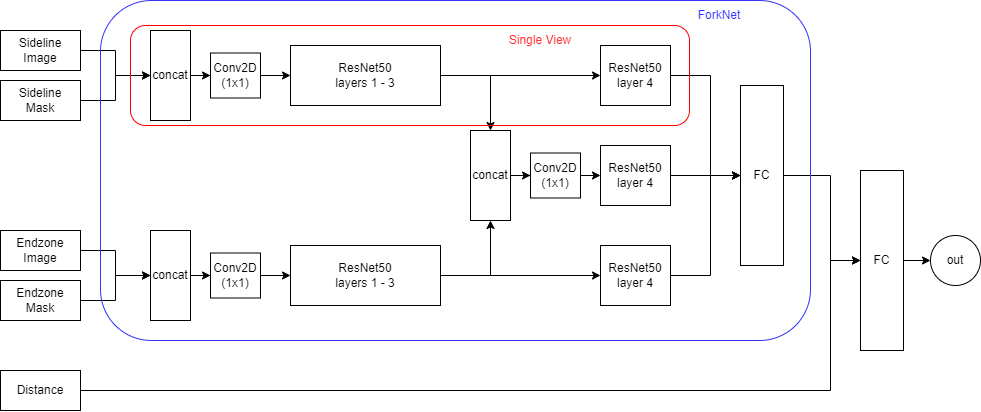

The model proposed is a wide readaptation of the **ResNet50**. In this case each contact is examinated separately with a single image in input and a single classification value as output.

In particular each input consists of two 128x128 images:
- The first one is a cropping from the original frame of the contact that has to be analyzed (the image is centered at the center of the unified bounding box).
- The second one is a binary mask where only the pixels inside the contact box are set to one, otherwise is zero.
The process is repeated for both the sideline and the enzone

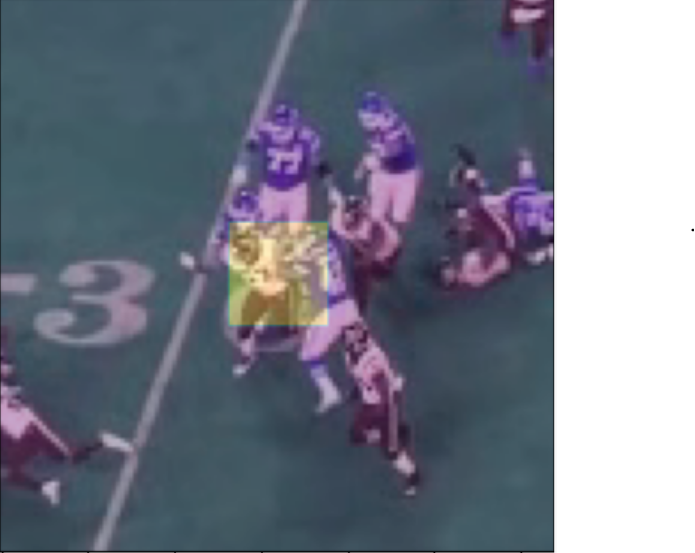

The input image and the mask (concatenated)

Each couple of inputs (*image and mask*) is passed to the same specular path:

- The two images are concatenated and passed throught a (1x1) *Conv2D* layer to broadcast the input shape from *(BATCH, 4, 128,128)* to *(BATCH, 3, 128, 128)* which is the shape accepted from the ResNet

- The obtained *tensor* is passed throught the first three layers of the resnet

- The two tensors coming out from the first three layers of the ResNet (one for the sideline and one for the endzone) are concatenated and again passed throught a (1x1) Conv2D layer to restore the shape needed.

- All the three tensors (sideline, Endzone, concatenated) are passed to the last layer of the ResNet

- A last fully connected layer is used for the classification

- this output is the concatenated with the **distance** value and passed to a last *Fully Connected* layer producing the final output

#### Fork network

In [ ]:
class ForkNet_SISL(torch.nn.Module):

  def __init__(self, resnet1, resnet2):
    super().__init__()
    self.resnet1 = resnet1
    self.resnet2 = resnet2
    self.fc = torch.nn.Linear(2048, 1)
    self.classifier = torch.nn.Linear(3,10)
    self.final = torch.nn.Linear(10,1)
    self.distance_checker = torch.nn.Linear(2,1)
    self.GlobAvg = torch.nn.AdaptiveAvgPool2d(1)
    self.conv2d = torch.nn.Conv2d(2048, 1024, (1,1))
    self.conv2d_init = torch.nn.Conv2d(4,3,(1,1))

  def forward(self, frame_side, frame_end, mask_side, mask_end, distance):
    x_s = torch.cat((frame_side, mask_side), dim=1)
    x_e = torch.cat((frame_end, mask_end), dim=1)

    x_s = self.conv2d_init(x_s)
    x_e = self.conv2d_init(x_e)

    x_s = self.resnet1.conv1(frame_side)
    x_s = self.resnet1.bn1(x_s)
    x_s = self.resnet1.relu(x_s)
    x_s = self.resnet1.maxpool(x_s)

    x_s = self.resnet1.layer1(x_s)
    x_s = self.resnet1.layer2(x_s)
    x_s = self.resnet1.layer3(x_s)

    x_e = self.resnet1.conv1(frame_end)
    x_e = self.resnet1.bn1(x_e)
    x_e = self.resnet1.relu(x_e)
    x_e = self.resnet1.maxpool(x_e)

    x_e = self.resnet1.layer1(x_e)
    x_e = self.resnet1.layer2(x_e)
    x_e = self.resnet1.layer3(x_e)

    middle = torch.cat((x_s, x_e), dim=1)

    out_s = self.resnet1.layer4(x_s)
    out_e = self.resnet2.layer4(x_e)

    out_m = self.conv2d(middle)
    out_m = self.resnet1.layer4(out_m)


    out_s = self.GlobAvg(out_s)
    out_e = self.GlobAvg(out_e)
    out_m = self.GlobAvg(out_m)

    logit_s = self.fc(out_s.reshape((-1, 2048)))
    logit_e = self.fc(out_e.reshape((-1, 2048)))
    logit_m = self.fc(out_m.reshape((-1, 2048)))


    out = torch.cat((logit_s, logit_m, logit_e), dim=1)
    out = self.classifier(out)
    out = self.final(out)

    out = torch.cat((out, torch.unsqueeze(distance, dim=-1).float()), dim=1)
    out = self.distance_checker(out)
    return out.squeeze(dim=1)
    #return self.sigmoid(out).squeeze(dim=1)

#Experiment


## SIML Model

### Hypeparameters

Here we set up an experiment environment to be able to control easily all the hyperparameters and to log them into wandb for later reference.

In [ ]:
datasets = {'small': (small_train_ds_SIML, small_val_ds_SIML),
            'large': (train_ds_SIML, val_ds_SIML),
            'augmented': (train_ds_aug_SIML, val_ds_SIML)}

losses = {'bce': bce_loss,
          'focal': focal_loss}

In [ ]:
LR = 0.001
EPOCHS = 10
BATCH_SIZE = 16
NAME_RUN = 'SplittedDoubleViewAug'
DATASET = 'augmented' # one between small - large - augmented
BIAS_INIT = True
TRAIN_STEM = False
TRAIN_EXTRACTOR = False
TRAIN_PER_REGION = True
VALIDATE_INTERVAL = -1 # -1 to validate and log at every epoch (1 wandb_step = 1 epoch). Otherwise validate and log every n steps (1 wandb_step = n steps)
VIEW = 'Both' # one between Sideline - Endzone - Both
SHARED = False
LOSS = 'bce'

In [ ]:
wandb.init(project= "NFL_Project", name=NAME_RUN,
           config={'lr': LR,
                   'epochs': EPOCHS,
                   'batch_size': BATCH_SIZE,
                   'dataset': DATASET,
                   'bias_init': BIAS_INIT,
                   'train_stem': TRAIN_STEM,
                   'train_extractor': TRAIN_EXTRACTOR,
                   'train_per_region': TRAIN_PER_REGION,
                   'view': VIEW,
                   'shared': SHARED,
                   'loss': LOSS})

### Dataloaders

In [ ]:
num_workers = 2

batch_size = BATCH_SIZE

loader_train = torch.utils.data.DataLoader(datasets[DATASET][0], batch_size=batch_size,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=num_workers)
loader_val = torch.utils.data.DataLoader(datasets[DATASET][1], batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=num_workers)
loader_test = torch.utils.data.DataLoader(test_ds_SIML, batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=num_workers)

### Networks

In [ ]:
resnet = torchvision.models.resnet50(weights=weights)
if VIEW == 'Both' and SHARED == False:
  resnet2 = torchvision.models.resnet50(weights=weights)

Here we control the freezing of the training of ResNet50 leayers of either or both the FeatureExtractor and the PerRegion net.

In [ ]:
set_requires_grad_for_layer(resnet.conv1, TRAIN_STEM)
set_requires_grad_for_layer(resnet.bn1, TRAIN_STEM)
set_requires_grad_for_layer(resnet.layer1, TRAIN_EXTRACTOR)
set_requires_grad_for_layer(resnet.layer2, TRAIN_EXTRACTOR)
set_requires_grad_for_layer(resnet.layer3, TRAIN_EXTRACTOR)
set_requires_grad_for_layer(resnet.layer4, TRAIN_PER_REGION)

Here we allow three different possibilities:

- Using both views and sharing the weights of the OneView network

- Using both views and using two separate the OneView networks

- Using a single view







In [ ]:
feature_extractor = FeatureExtractorNet(resnet)
prn = PerRegionNet(resnet)
one_view = OneViewNet(feature_extractor, prn, device)

if VIEW == 'Both' and SHARED == False:
    feature_extractor2 = FeatureExtractorNet(resnet)
    prn2 = PerRegionNet(resnet)
    one_view2 = OneViewNet(feature_extractor2, prn2, device)
    fork = ForkNet1(one_view, one_view2)
elif VIEW == 'Both':
  model_SIML = ForkNet1(one_view, one_view)
else:
  model_SIML = ForkNet2(one_view, VIEW)

model_SIML.to(device);

### Bias initialization

Bias initialization following Andrej Karpathy blog article.

In [ ]:
if BIAS_INIT:
  pi = loss_count[1] / (loss_count[0] + loss_count[1])
  bias = -np.log((1 - pi) / pi)
  prn.fc.bias = torch.nn.Parameter(torch.tensor(bias, dtype=torch.float32).to(device))
  if VIEW == 'Both' and SHARED == False:
    prn2.fc.bias = torch.nn.Parameter(torch.tensor(bias, dtype=torch.float32).to(device))

### Train

Here we run the training.

In [ ]:
wandb.watch(model_SIML)

optimizer = torch.optim.AdamW(model_SIML.parameters(), lr=LR)

training_loop(
    model_SIML,
    loader_train,
    loader_val,
    EPOCHS,
    optimizer,
    losses[LOSS],
    compute_metrics,
    device,
    validate_interval=VALIDATE_INTERVAL,
    saving_path = f"{BASE_DIR}/models/{NAME_RUN}.pt",
    metric_monitor = "f1")

wandb.finish()

In [ ]:
wandb.finish()

### Predictions results

In [ ]:
model_SIML.load_state_dict(torch.load(f"{BASE_DIR}/models/{NAME_RUN}.pt"))

<All keys matched successfully>

In [ ]:
prediction_results = predict(model_SIML, loader_test, losses[LOSS], compute_metrics, device)

  0%|          | 0/24 [00:00<?, ?it/s]

Let's have a look at the metrics computed from this model

In [ ]:
prediction_results[1]

{'accuracy': 0.8105196451204055,
 'f1': 0.6199496494644829,
 'precision': 0.6061671179883884,
 'recall': 0.6511332932045837,
 'loss': 0.6002806000723132}

We must now handle the predictions to transform the probabilties into actual choices

In [ ]:
predictions = prediction_results[0].reshape((-1, 231))

In [ ]:
predictions = predictions.to('cpu')

predictions[np.where(predictions >= 0.5)] = 1
predictions[np.where(predictions < 0.5)] = 0

Here it is possible to see the predicted outputs.


*   Green -> True positive
*   Blue -> True negative
*   Red -> False postive
*   Black -> False negative



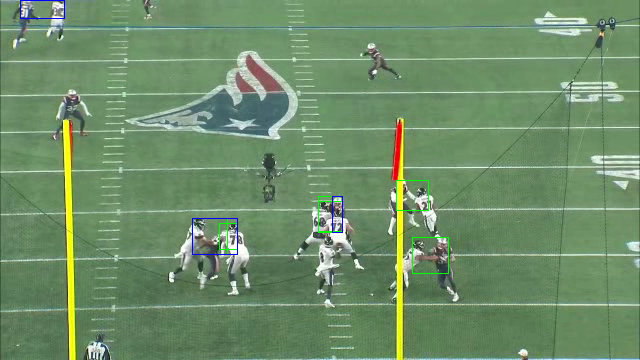

In [ ]:
#@title Prediction visualization

INDEX_EXAMPLE = 194 #@param {type:"slider", min:0, max:383, step:1}
VIEW = "Endzone" #@param ["Sideline", "Endzone"]

input, true_contacts = test_ds_SIML.__getitem__(INDEX_EXAMPLE)
predicted_contacts = predictions[INDEX_EXAMPLE, :]

show_prediction(input, true_contacts, predicted_contacts, VIEW)

## SISL Model

#### Hyperparameters

In [ ]:
LR = 0.0001
EPOCHS = 1
BATCH_SIZE = 64
NAME_RUN = 'ForkNet_SISL'
DATASET = 'large' # one between small - large
VALIDATE_INTERVAL = 1000 # -1 to validate and log at every epoch (1 wandb_step = 1 epoch). Otherwise validate and log every n steps (1 wandb_step = n steps)

wandb.init(project= "NFL", name=NAME_RUN,
            config={'lr': LR,
                    'epochs': EPOCHS,
                    'batch_size': BATCH_SIZE,
                    'dataset': DATASET})

#### Dataloaders

In [ ]:
num_workers = 0

loader_train = torch.utils.data.DataLoader(train_ds_SISL, batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=num_workers)
loader_val = torch.utils.data.DataLoader(val_ds_SISL, batch_size=BATCH_SIZE,
                                         shuffle=False,
                                         num_workers=num_workers)
loader_test = torch.utils.data.DataLoader(test_ds_SISL, batch_size=BATCH_SIZE,
                                         shuffle=False,
                                         num_workers=num_workers)

#### Networks

In [ ]:
weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
resnet_s = torchvision.models.resnet50(weights=weights)
resnet_e = torchvision.models.resnet50(weights=weights)

In [ ]:
set_requires_grad_for_layer(resnet_s.conv1, True)
set_requires_grad_for_layer(resnet_s.bn1, True)
set_requires_grad_for_layer(resnet_s.layer1, True)
set_requires_grad_for_layer(resnet_s.layer2, True)
set_requires_grad_for_layer(resnet_s.layer3, True)
set_requires_grad_for_layer(resnet_s.layer4, True)

set_requires_grad_for_layer(resnet_e.conv1, True)
set_requires_grad_for_layer(resnet_e.bn1, True)
set_requires_grad_for_layer(resnet_e.layer1, True)
set_requires_grad_for_layer(resnet_e.layer2, True)
set_requires_grad_for_layer(resnet_e.layer3, True)
set_requires_grad_for_layer(resnet_e.layer4, True)

In [ ]:
model_SISL = ForkNet_SISL(resnet_s, resnet_e)

#### Train

In [ ]:
try:
  wandb.watch(model_SISL)

  training_loop(
    model_SISL,
    loader_train,
    loader_val,
    EPOCHS,
    torch.optim.AdamW(model_SISL.parameters(), lr=LR),
    bce_loss,
    compute_metrics,
    device,
    validate_interval = VALIDATE_INTERVAL,
    saving_path = f"{BASE_DIR}/models/ForkNet_SISL.pt",
    metric_monitor = "f1_score"
  )

  wandb.finish()

except Exception as e:
  print(e)
  wandb.finish()

### Prediction results


In [ ]:
model_SISL.load_state_dict(torch.load(f"{BASE_DIR}/{QUALITY}/models/ForkNet_SISL.pt"))
model_SISL.to(device)

In [ ]:
predictions = predict(
    model_SISL,
    loader_test,
    bce_loss_no_mask,
    compute_metrics,
    device,
    has_mask=False
)

  0%|          | 0/617 [00:00<?, ?it/s]

Let's take a look to the metrics of the second model

In [ ]:
predictions[1]

{'accuracy': 0.9879203808752026,
 'f1': 0.8349155429824178,
 'precision': 0.8567490300053655,
 'recall': 0.8301631640972676,
 'loss': 0.03236744172921915}

For better understanding the impact of the net on the datas (many of the entries are labeled as 'non contact') the **Matthews Correlation Coefficient** is reported

In [ ]:
predictions[0][predictions[0] >= 0.5] = 1
predictions[0][predictions[0] < 0.5] = 0

In [ ]:
matt_c = matthews_corrcoef(test_df_SISL.contact, predictions[0].detach().cpu().numpy())
print(f"Matthews Correlation Coeff: {matt_c}")

Matthews Correlation Coeff: 0.6493601419371635


### Prediction Visualization

Dropdown(options=('58168_003392', '58172_003247', '58173_003606', '58174_001792', '58176_002844', '58177_00423…

Dropdown(options=(), value=None)

Output()

Output()

Calculating predictions...
Creating graphs...


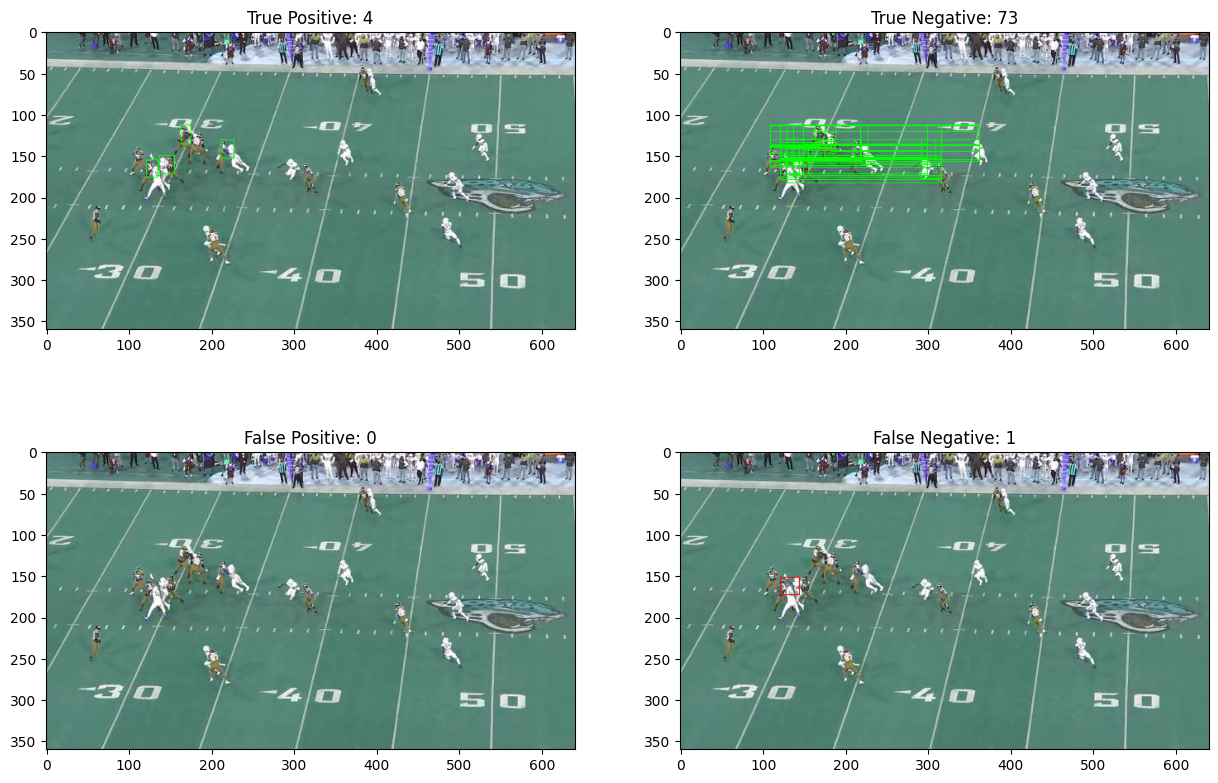

In [ ]:
#@title
dropdown_gp = widgets.Dropdown(options = test_df_SISL.game_play.unique())
dropdown_frame = widgets.Dropdown(options=[])
output = widgets.Output()
view = "Sideline"

def select_gp(change):
  output.clear_output()
  game_play = change.new
  dropdown_frame.options = test_df_SISL[test_df_SISL.game_play == game_play].frame.unique()
  dropdown_frame.observe(select_frame, names="value")
  display(output)

def select_frame(change):
  output.clear_output()
  frame = int(change.new)
  game_play = dropdown_gp.get_interact_value()
  inputs_from_gpframe(game_play, frame, test_df_SISL, model_SISL)


dropdown_gp.observe(select_gp, names="value")
display(dropdown_gp)
display(dropdown_frame)
display(output)

## Models Comparison

### Comparable Dataset

Since the two networks are trained on different entries (the SIML based models do not deal with entries whose *distance* values are greater then the selected *treshold*) a **comparable dataset** with the same elements for both is created in order to have a realistic comparison of the two models

In [ ]:
test_df_comparison = test_df_SISL[test_df_SISL.loss_mask]

In [ ]:
test_ds_comparison_SISL = NFLDataset_SISL(test_df_comparison, test_sideline, test_endzone)
test_ds_comparison_SIML = NFLDataset_SIML(test_df, test_sideline, test_endzone, test_keys)

In [ ]:
loader_test_comparison_SISL = torch.utils.data.DataLoader(test_ds_comparison_SISL, batch_size=BATCH_SIZE,
                                         shuffle=False,
                                         num_workers=0)

loader_test_comparison_SIML = torch.utils.data.DataLoader(test_ds_comparison_SIML, batch_size=BATCH_SIZE,
                                         shuffle=False,
                                         num_workers=num_workers)

### OneViewNet Sideline

In [ ]:
model_SIML = ForkNet2(one_view, "Sideline")
model_SIML.to(device);

In [ ]:
model_SIML.load_state_dict(torch.load(f"{BASE_DIR}/models/OneViewSideline.pt"))

<All keys matched successfully>

In [ ]:
predictions_OVS = predict(
    model_SIML,
    loader_test_comparison_SIML,
    bce_loss,
    compute_metrics,
    device
)

  0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
predictions_OVS[1]

{'accuracy': 0.7642585551330798,
 'f1': 0.3927756172119704,
 'precision': 0.5536266876395934,
 'recall': 0.3235884988886581,
 'loss': 0.5758205649498449}

In [ ]:
predictions_OVS[0][predictions_OVS[0] >= 0.5] = 1
predictions_OVS[0][predictions_OVS[0] < 0.5] = 0

In [ ]:
matt_c = matthews_corrcoef(test_df.contact, predictions_OVS[0].detach().cpu().numpy())
print(f"Matthews Correlation Coeff: {matt_c}")

Matthews Correlation Coeff: -0.2789539016915397


### OneView Endzone

In [ ]:
model_SIML = ForkNet2(one_view, "Endzone")
model_SIML.to(device);

In [ ]:
model_SIML.load_state_dict(torch.load(f"{BASE_DIR}/models/OneViewEndzone.pt"))

<All keys matched successfully>

In [ ]:
predictions_OVE = predict(
    model_SIML,
    loader_test_comparison_SIML,
    bce_loss,
    compute_metrics,
    device
)

  0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
predictions_OVE[1]

{'accuracy': 0.800063371356147,
 'f1': 0.5620019546772769,
 'precision': 0.5947497412185743,
 'recall': 0.5446707229843435,
 'loss': 0.739815578431231}

In [ ]:
predictions_OVE[0][predictions_OVE[0] >= 0.5] = 1
predictions_OVE[0][predictions_OVE[0] < 0.5] = 0

In [ ]:
matt_c = matthews_corrcoef(test_df.contact, predictions_OVE[0].detach().cpu().numpy())
print(f"Matthews Correlation Coeff: {matt_c}")

Matthews Correlation Coeff: -0.2021024670464579


### ForkNet SIML (Shared params)

In [ ]:
model_SIML = ForkNet1(one_view, one_view)
model_SIML.to(device);

In [ ]:
model_SIML.load_state_dict(torch.load(f"{BASE_DIR}/models/SharedDoubleView.pt"))

<All keys matched successfully>

In [ ]:
predictions_SDV = predict(
    model_SIML,
    loader_test_comparison_SIML,
    bce_loss,
    compute_metrics,
    device
)

  0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
predictions_SDV[1]

{'accuracy': 0.8105196451204055,
 'f1': 0.6199496494644829,
 'precision': 0.6061671179883884,
 'recall': 0.6511332932045837,
 'loss': 0.6002806000723132}

In [ ]:
predictions_SDV[0][predictions_SDV[0] >= 0.5] = 1
predictions_SDV[0][predictions_SDV[0] < 0.5] = 0

In [ ]:
matt_c = matthews_corrcoef(test_df.contact, predictions_SDV[0].detach().cpu().numpy())
print(f"Matthews Correlation Coeff: {matt_c}")

Matthews Correlation Coeff: 0.5714428645304628


### ForkNet SIML (splitted params)

In [ ]:
model_SIML = ForkNet1(one_view, one_view2)
model_SIML.to(device);

In [ ]:
model_SIML.load_state_dict(torch.load(f"{BASE_DIR}/models/SplittedDoubleView.pt"))

<All keys matched successfully>

In [ ]:
predictions_SPDV = predict(
    model_SIML,
    loader_test_comparison_SIML,
    bce_loss,
    compute_metrics,
    device
)

  0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
predictions_SPDV[1]

{'accuracy': 0.8244613434727504,
 'f1': 0.6052367923207388,
 'precision': 0.6616294324163267,
 'recall': 0.5720771131485698,
 'loss': 0.705896052901358}

In [ ]:
predictions_SPDV[0][predictions_SPDV[0] >= 0.5] = 1
predictions_SPDV[0][predictions_SPDV[0] < 0.5] = 0

In [ ]:
matt_c = matthews_corrcoef(test_df.contact, predictions_SPDV[0].detach().cpu().numpy())
print(f"Matthews Correlation Coeff: {matt_c}")

Matthews Correlation Coeff: 0.5667412954004111


### ForkNet SISL

In [ ]:
model_SISL = ForkNet_SISL(resnet_s, resnet_e)
model_SISL.to(device);

In [ ]:
model_SISL.load_state_dict(torch.load(f"{BASE_DIR}/{QUALITY}/models/ForkNet_SISL.pt"))

<All keys matched successfully>

In [ ]:
predictions_comp = predict(
    model_SISL,
    loader_test_comparison_SISL,
    bce_loss_no_mask,
    compute_metrics,
    device,
    has_mask=False
)

  0%|          | 0/198 [00:00<?, ?it/s]

In [ ]:
predictions_comp[1]

{'accuracy': 0.8512836700336701,
 'f1': 0.44527540608200133,
 'precision': 0.5732663940997273,
 'recall': 0.3940968122786304,
 'loss': 0.3448457710851793}

In [ ]:
predictions_comp[0][predictions_comp[0] < 0.5] = 0
predictions_comp[0][predictions_comp[0] >= 0.5] = 1

In [ ]:
matt_c = matthews_corrcoef(test_df_comparison.contact, predictions_comp[0].detach().cpu().numpy())
print(f"Matthews Correlation Coeff: {matt_c}")

Matthews Correlation Coeff: 0.5766025053382894
